In [5]:
# ============================================================
# Flat CK+ ➜ DVS events  (symlink-safe version)
# ============================================================

CK_ROOT    = "/kaggle/input/ck-dataset"
OUT_ROOT   = "/kaggle/working/ck_v2e_out"
TMP_ROOT   = "/kaggle/working/_v2e_tmp"
FRAME_RATE = 30
USE_SLOMO  = False

import os, re, glob, shutil, subprocess, pathlib, tempfile, sys
from tqdm.auto import tqdm
os.makedirs(OUT_ROOT, exist_ok=True)
os.makedirs(TMP_ROOT, exist_ok=True)

# 1) lightweight deps
!pip install -q ffmpeg-python imageio[ffmpeg] pims opencv-python-headless tqdm pillow requests gdown

# 2) clone v2e once
WORKING, V2E_DIR = "/kaggle/working", "/kaggle/working/v2e"
if not os.path.isdir(V2E_DIR):
    subprocess.run(["git","clone","--depth","1","https://github.com/SensorsINI/v2e.git",V2E_DIR], check=True)
    subprocess.run(["pip","install","-q","-e",V2E_DIR], check=True)

MODEL_PATH=""
if USE_SLOMO:
    MODEL_PATH=f"{V2E_DIR}/v2e_networks/SuperSloMo39.pth.tar"
    if not os.path.isfile(MODEL_PATH):
        subprocess.run(["gdown","--id","1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx","-O",MODEL_PATH], check=True)

# 3) discover sequences (prefix grouping)
pat=re.compile(r"^(S\d+_\d+)_\d+\.png$",re.I)
seqs={}
for emo in sorted(d for d in os.listdir(CK_ROOT) if os.path.isdir(f"{CK_ROOT}/{d}")):
    for png in glob.glob(f"{CK_ROOT}/{emo}/*.png"):
        m=pat.match(os.path.basename(png))
        if not m: continue
        prefix=m.group(1)
        seqs.setdefault((emo,prefix),[]).append(png)

print("✅  Discovered",len(seqs),"sequences.")

# 4) run v2e
records=[]
for (emo,prefix),frames in tqdm(seqs.items(),desc="v2e"):
    if len(frames)<2: continue
    frames.sort(key=lambda x:int(re.search(r"_(\d+)\.png$",x).group(1)))

    tmp_dir=tempfile.mkdtemp(dir=TMP_ROOT)
    for idx,src in enumerate(frames,1):
        dst=f"{tmp_dir}/{idx:08d}.png"
        try:
            os.symlink(src,dst)        # fastest
        except OSError:
            shutil.copy2(src,dst)      # fallback

    out_dir=f"{OUT_ROOT}/{emo}/{prefix}"
    os.makedirs(out_dir,exist_ok=True)

    cmd=["python",f"{V2E_DIR}/v2e.py",
         "-i",tmp_dir,"-o",out_dir,
         "--input_frame_rate",str(FRAME_RATE),
         "--dvs_exposure","duration","0.01",
         "--cutoff_hz","300","--overwrite","--no_preview"]
    cmd+=["--slomo_model",MODEL_PATH] if USE_SLOMO else ["--disable_slomo"]

    run=subprocess.run(cmd,stdout=subprocess.PIPE,stderr=subprocess.PIPE,text=True)
    shutil.rmtree(tmp_dir,ignore_errors=True)

    if run.returncode==0:
        records.append({"emotion":emo,"sequence":prefix,
                        "num_frames":len(frames),"events":out_dir})
    else:
        print(f"\n❌  {emo}/{prefix} failed\n{run.stderr}")

# 5) save CSV
import pandas as pd
if records:
    csv_path=f"{OUT_ROOT}/ck_v2e_summary.csv"
    pd.DataFrame(records).to_csv(csv_path,index=False)
    print(f"\n✅  Converted {len(records)} sequences.")
    print("📄  Summary CSV:",csv_path)
else:
    print("\n⚠️  v2e failed on every sequence.")


✅  Discovered 327 sequences.


v2e:   0%|          | 0/327 [00:00<?, ?it/s]


✅  Converted 327 sequences.
📄  Summary CSV: /kaggle/working/ck_v2e_out/ck_v2e_summary.csv


In [1]:
# lightweight deps (as before)
!pip install -q ffmpeg-python imageio[ffmpeg] pims \
    opencv-python-headless tqdm pillow requests gdown

# 🔧 ↓↓ pin NumPy & Numba to compatible versions ↓↓
!pip install -q --force-reinstall "numpy==1.26.4" "numba==0.59.1"

# (everything else stays the same)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 80.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 84.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 15.3 MB/s eta 0:00:0000:0100:01m
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you ha

In [4]:
!pip install dv_processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 94.6 MB/s eta 0:00:00:00:0100:01


In [6]:
# compress the whole v2e result folder
!zip -r /kaggle/working/ck_v2e_out.zip /kaggle/working/ck_v2e_out


  adding: kaggle/working/ck_v2e_out/ (stored 0%)
  adding: kaggle/working/ck_v2e_out/anger/ (stored 0%)
  adding: kaggle/working/ck_v2e_out/anger/S028_001/ (stored 0%)
  adding: kaggle/working/ck_v2e_out/anger/S028_001/dvs-video.avi (deflated 70%)
  adding: kaggle/working/ck_v2e_out/anger/S028_001/dvs-video-frame_times.txt (deflated 35%)
  adding: kaggle/working/ck_v2e_out/anger/S028_001/v2e-args.txt (deflated 63%)
  adding: kaggle/working/ck_v2e_out/anger/S034_003/ (stored 0%)
  adding: kaggle/working/ck_v2e_out/anger/S034_003/dvs-video.avi (deflated 66%)
  adding: kaggle/working/ck_v2e_out/anger/S034_003/dvs-video-frame_times.txt (deflated 32%)
  adding: kaggle/working/ck_v2e_out/anger/S034_003/v2e-args.txt (deflated 63%)
  adding: kaggle/working/ck_v2e_out/anger/S029_001/ (stored 0%)
  adding: kaggle/working/ck_v2e_out/anger/S029_001/dvs-video.avi (deflated 60%)
  adding: kaggle/working/ck_v2e_out/anger/S029_001/dvs-video-frame_times.txt (deflated 36%)
  adding: kaggle/working/ck_v2

In [19]:
# ============================================================
# CK+ DVS → AlexNet & AlexNet+LSTM training & evaluation
# (with robust zero‑frame filtering)
# ============================================================

# ─── 0) CONFIG ─────────────────────────────────────────────
CSV_PATH    = "/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
IMG_PATTERN = "dvs_frame_*.png"
BATCH_SIZE  = 32
SEQ_LEN     = 20      # LSTM sees first 20 frames
EPOCHS      = 10
LR          = 1e-5
VAL_SPLIT   = 0.1     # 10% val + 10% test
NUM_WORKERS = 2

import os, glob, random, cv2
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ─── 1) DEPENDENCIES ────────────────────────────────────────
!pip install -q scikit-learn

# ─── 2) LOAD, RENAME & FILTER CSV ──────────────────────────
df = pd.read_csv(CSV_PATH)
# handle old vs new column name
if "events_folder" not in df.columns and "events" in df.columns:
    df = df.rename(columns={"events":"events_folder"})

def count_frames(folder):
    # count PNGs
    pngs = glob.glob(os.path.join(folder, IMG_PATTERN))
    if pngs:
        return len(pngs)
    # else count AVI frames via metadata
    avi = os.path.join(folder, "dvs-video.avi")
    if os.path.isfile(avi):
        cap = cv2.VideoCapture(avi)
        cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return cnt
    return 0

# compute and filter
df["nframes"] = df["events_folder"].apply(count_frames)
df = df[df["nframes"] > 0].reset_index(drop=True)
print(f"Kept {len(df)} sequences with ≥1 frame (out of original).")

# ─── 3) DATASET ─────────────────────────────────────────────
class DVSSequenceDataset(Dataset):
    def __init__(self, df, max_frames, pattern, transform, mode="single"):
        self.df = df.reset_index(drop=True)
        self.max_frames, self.pattern = max_frames, pattern
        self.tf, self.mode = transform, mode
        self.lbl2id = {l:i for i,l in enumerate(sorted(df["emotion"].unique()))}

    def __len__(self):
        return len(self.df)

    def _load_frames(self, folder):
        pngs = sorted(glob.glob(os.path.join(folder, self.pattern)))
        if pngs:
            return [Image.open(p).convert("L") for p in pngs]
        # else fall back to AVI
        avi = os.path.join(folder, "dvs-video.avi")
        cap, imgs = cv2.VideoCapture(avi), []
        ret, frame = cap.read()
        while ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            imgs.append(Image.fromarray(gray))
            ret, frame = cap.read()
        cap.release()
        return imgs

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        frames = self._load_frames(row.events_folder)

        # single‑frame mode: pick densest
        if self.mode == "single":
            densest = max(frames, key=lambda im: np.array(im).sum())
            img = self.tf(densest)
            return img, self.lbl2id[row.emotion]

        # sequence mode: pad/truncate to max_frames
        frames = frames[:self.max_frames]
        while len(frames) < self.max_frames:
            frames.append(frames[-1])
        seq = torch.stack([self.tf(im) for im in frames])  # (T,C,H,W)
        return seq, self.lbl2id[row.emotion]

# transforms (shared)
cxform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# ─── 4) SPLIT & BUILD LOADERS ──────────────────────────────
random.seed(0); torch.manual_seed(0)
n = len(df); n_val = int(n*VAL_SPLIT)
perm = np.random.permutation(n)
idx_tr, idx_val, idx_te = perm[n_val*2:], perm[:n_val], perm[n_val:n_val*2]

train_df, val_df, test_df = df.iloc[idx_tr], df.iloc[idx_val], df.iloc[idx_te]

# datasets
single_train = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, cxform, "single")
single_val   = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, cxform, "single")
single_test  = DVSSequenceDataset(test_df,  SEQ_LEN, IMG_PATTERN, cxform, "single")

seq_train = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, cxform, "sequence")
seq_val   = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, cxform, "sequence")

# loaders
single_loader = {
    "train": DataLoader(single_train, BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(single_val,   BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
}
seq_loader = {
    "train": DataLoader(seq_train, BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(seq_val,   BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
}

# ─── 5) MODEL A : AlexNet single‐frame ─────────────────────
alex = models.alexnet(weights=None)
alex.features[0] = nn.Conv2d(1,64,11,stride=4,padding=2)
alex.classifier[6] = nn.Linear(4096, len(single_train.lbl2id))
alex.to(device)

# ─── 6) MODEL B : AlexNet + LSTM sequence ──────────────────
class AlexLSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.alexnet(weights=None)
        base.features[0] = nn.Conv2d(1,64,11,stride=4,padding=2)
        self.cnn  = nn.Sequential(*list(base.features), base.avgpool)
        self.flat = nn.Flatten()
        self.lstm = nn.LSTM(9216,256,batch_first=True)
        self.head = nn.Linear(256,num_classes)
    def forward(self,x):
        B,T = x.shape[0], x.shape[1]
        feats = self.cnn(x.view(B*T,1,224,224))
        feats = self.flat(feats).view(B,T,-1)
        _,(h,_) = self.lstm(feats)
        return self.head(h.squeeze(0))

alexlstm = AlexLSTM(len(seq_train.lbl2id)).to(device)

# ─── 7) TRAIN/VALID LOOP ───────────────────────────────────
def train_model(model, loaders, name):
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()
    hist = {"epoch":[], "tr_loss":[], "tr_acc":[], "val_loss":[], "val_acc":[]}
    for ep in range(1, EPOCHS+1):
        for phase in ("train","val"):
            getattr(model, "train" if phase=="train" else "eval")()
            rl, rc, tot = 0.0, 0, 0
            with torch.set_grad_enabled(phase=="train"):
                for X,y in loaders[phase]:
                    X,y = X.to(device), y.to(device)
                    if phase=="train": opt.zero_grad()
                    out = model(X)
                    loss = crit(out,y)
                    if phase=="train": loss.backward(); opt.step()
                    preds = out.argmax(1)
                    rl  += loss.item()*y.size(0)
                    rc  += (preds==y).sum().item()
                    tot += y.size(0)
            loss_ep = rl/tot; acc_ep = rc/tot
            (hist["tr_loss"] if phase=="train" else hist["val_loss"]).append(loss_ep)
            (hist["tr_acc"]  if phase=="train" else hist["val_acc"]).append(acc_ep)
        hist["epoch"].append(ep)
        print(f"[{name}] Ep{ep}/{EPOCHS} tr_acc {hist['tr_acc'][-1]:.3f} val_acc {hist['val_acc'][-1]:.3f}")
    return hist

hist_single = train_model(alex, single_loader,    "AlexNet")
hist_seq    = train_model(alexlstm, seq_loader,    "AlexNet+LSTM")

# ─── 8) EVALUATION & METRICS ───────────────────────────────
def evaluate(model, dataset):
    model.eval(); yt, yp = [], []
    loader = DataLoader(dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    with torch.no_grad():
        for X,y in loader:
            out = model(X.to(device))
            yt.extend(y.tolist()); yp.extend(out.argmax(1).cpu().tolist())
    acc = accuracy_score(yt,yp)
    pr, rc, f1, _ = precision_recall_fscore_support(yt,yp,average="weighted",zero_division=0)
    return acc, pr, rc, f1

m_s   = evaluate(alex,    single_test)
m_seq = evaluate(alexlstm, seq_test)
print("Single‑frame AlexNet  – acc {:.3f}  prec {:.3f}  rec {:.3f}  f1 {:.3f}".format(*m_s))
print("Seq‑AlexNet+LSTM      – acc {:.3f}  prec {:.3f}  rec {:.3f}  f1 {:.3f}".format(*m_seq))

#


Using device: cuda
Kept 324 sequences with ≥1 frame (out of original).
[AlexNet] Ep1/10 tr_acc 0.177 val_acc 0.094
[AlexNet] Ep2/10 tr_acc 0.231 val_acc 0.062
[AlexNet] Ep3/10 tr_acc 0.250 val_acc 0.000
[AlexNet] Ep4/10 tr_acc 0.238 val_acc 0.000
[AlexNet] Ep5/10 tr_acc 0.238 val_acc 0.000
[AlexNet] Ep6/10 tr_acc 0.238 val_acc 0.000
[AlexNet] Ep7/10 tr_acc 0.238 val_acc 0.000
[AlexNet] Ep8/10 tr_acc 0.246 val_acc 0.000
[AlexNet] Ep9/10 tr_acc 0.269 val_acc 0.000
[AlexNet] Ep10/10 tr_acc 0.254 val_acc 0.000
[AlexNet+LSTM] Ep1/10 tr_acc 0.123 val_acc 0.094
[AlexNet+LSTM] Ep2/10 tr_acc 0.227 val_acc 0.094
[AlexNet+LSTM] Ep3/10 tr_acc 0.227 val_acc 0.094
[AlexNet+LSTM] Ep4/10 tr_acc 0.238 val_acc 0.062
[AlexNet+LSTM] Ep5/10 tr_acc 0.285 val_acc 0.031
[AlexNet+LSTM] Ep6/10 tr_acc 0.281 val_acc 0.000
[AlexNet+LSTM] Ep7/10 tr_acc 0.238 val_acc 0.000
[AlexNet+LSTM] Ep8/10 tr_acc 0.238 val_acc 0.000
[AlexNet+LSTM] Ep9/10 tr_acc 0.235 val_acc 0.031
[AlexNet+LSTM] Ep10/10 tr_acc 0.238 val_acc 0.0

Using device: cuda
Kept 324 sequences with ≥1 frame


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ResNet18] Ep1/20 tr_acc 0.227 val_acc 0.094
[ResNet18] Ep2/20 tr_acc 0.327 val_acc 0.094
[ResNet18] Ep3/20 tr_acc 0.408 val_acc 0.031
[ResNet18] Ep4/20 tr_acc 0.485 val_acc 0.031
[ResNet18] Ep5/20 tr_acc 0.531 val_acc 0.188
[ResNet18] Ep6/20 tr_acc 0.669 val_acc 0.312
[ResNet18] Ep7/20 tr_acc 0.677 val_acc 0.406
[ResNet18] Ep8/20 tr_acc 0.704 val_acc 0.469
[ResNet18] Ep9/20 tr_acc 0.742 val_acc 0.469
[ResNet18] Ep10/20 tr_acc 0.669 val_acc 0.469
[ResNet18] Ep11/20 tr_acc 0.727 val_acc 0.438
[ResNet18] Ep12/20 tr_acc 0.708 val_acc 0.438
[ResNet18] Ep13/20 tr_acc 0.746 val_acc 0.438
[ResNet18] Ep14/20 tr_acc 0.769 val_acc 0.406
[ResNet18] Ep15/20 tr_acc 0.742 val_acc 0.438
[ResNet18] Ep16/20 tr_acc 0.785 val_acc 0.438
[ResNet18] Ep17/20 tr_acc 0.681 val_acc 0.406
[ResNet18] Ep18/20 tr_acc 0.773 val_acc 0.438
[ResNet18] Ep19/20 tr_acc 0.746 val_acc 0.438
[ResNet18] Ep20/20 tr_acc 0.769 val_acc 0.438
[ResNet18+LSTM] Ep1/20 tr_acc 0.212 val_acc 0.156
[ResNet18+LSTM] Ep2/20 tr_acc 0.385 val

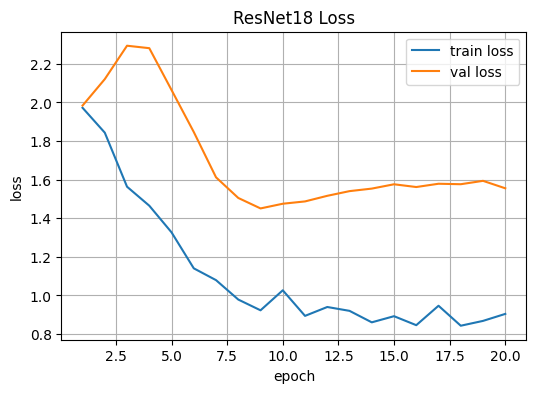

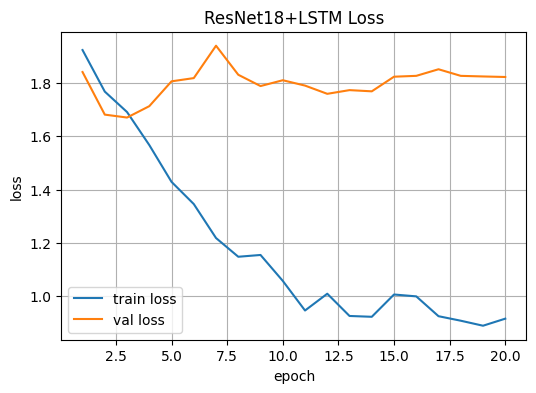

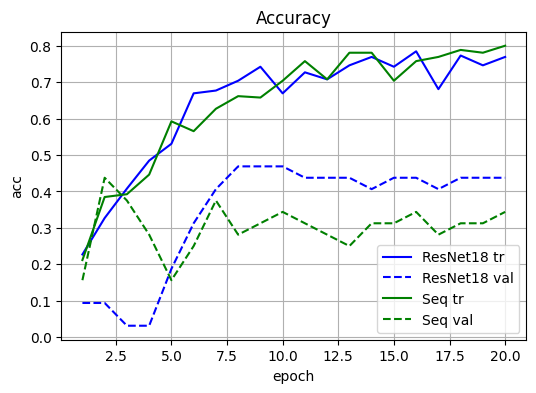

In [21]:
# ============================================================
# CK+ DVS → Transfer‐Learning with ResNet18 & LSTM (fixed train loop)
# ============================================================

# ─── 0) CONFIG ─────────────────────────────────────────────
CSV_PATH     = "/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
IMG_PATTERN  = "dvs_frame_*.png"
BATCH_SIZE   = 32
SEQ_LEN      = 20
EPOCHS       = 20
LR           = 1e-4
VAL_SPLIT    = 0.1
WEIGHT_DECAY = 1e-5
STEP_SIZE    = 7
GAMMA        = 0.1
NUM_WORKERS  = 4

import os, glob, random, cv2
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ─── 1) DEPENDENCIES ────────────────────────────────────────
!pip install -q scikit-learn

# ─── 2) LOAD, RENAME & FILTER CSV ──────────────────────────
df = pd.read_csv(CSV_PATH)
if "events_folder" not in df.columns and "events" in df.columns:
    df = df.rename(columns={"events":"events_folder"})

def count_frames(folder):
    pngs = glob.glob(os.path.join(folder, IMG_PATTERN))
    if pngs:
        return len(pngs)
    avi = os.path.join(folder, "dvs-video.avi")
    if os.path.isfile(avi):
        cap = cv2.VideoCapture(avi)
        cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return cnt
    return 0

df["nframes"] = df["events_folder"].apply(count_frames)
df = df[df["nframes"]>0].reset_index(drop=True)
print(f"Kept {len(df)} sequences with ≥1 frame")

# ─── 3) SPLIT ───────────────────────────────────────────────
random.seed(0); torch.manual_seed(0)
n = len(df); n_val = int(n*VAL_SPLIT)
perm = np.random.permutation(n)
idx_tr, idx_val, idx_te = perm[n_val*2:], perm[:n_val], perm[n_val:n_val*2]
train_df, val_df, test_df = df.iloc[idx_tr], df.iloc[idx_val], df.iloc[idx_te]

# ─── 4) DATASET ─────────────────────────────────────────────
class DVSSequenceDataset(Dataset):
    def __init__(self, df, max_frames, pattern, tfm, mode="single"):
        self.df = df.reset_index(drop=True)
        self.max_frames, self.pattern = max_frames, pattern
        self.tf, self.mode = tfm, mode
        self.lbl2id = {l:i for i,l in enumerate(sorted(df["emotion"].unique()))}
    def __len__(self): return len(self.df)
    def _load_frames(self, folder):
        pngs = sorted(glob.glob(os.path.join(folder, self.pattern)))
        if pngs:
            return [Image.open(p).convert("L") for p in pngs]
        imgs, cap = [], cv2.VideoCapture(os.path.join(folder, "dvs-video.avi"))
        ret,frame = cap.read()
        while ret:
            imgs.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)))
            ret,frame = cap.read()
        cap.release()
        return imgs
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        frames = self._load_frames(row.events_folder)
        if self.mode=="single":
            densest = max(frames, key=lambda im: np.array(im).sum())
            return self.tf(densest), self.lbl2id[row.emotion]
        # sequence mode
        frames = frames[:self.max_frames]
        while len(frames)<self.max_frames:
            frames.append(frames[-1])
        seq = torch.stack([self.tf(f) for f in frames])
        return seq, self.lbl2id[row.emotion]

# ─── 5) TRANSFORMS ──────────────────────────────────────────
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

# ─── 6) DATALOADERS & SAMPLER ─────────────────────────────
counts = train_df['emotion'].value_counts().sort_index()
class_weights = 1.0/counts
sample_weights = train_df['emotion'].map(class_weights).values
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

single_train = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf, "single")
single_val   = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,   "single")
single_test  = DVSSequenceDataset(test_df,  SEQ_LEN, IMG_PATTERN, val_tf,   "single")
seq_train    = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf, "sequence")
seq_val      = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,   "sequence")

single_loader = {
    "train": DataLoader(single_train, BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(single_val,   BATCH_SIZE, shuffle=False,     num_workers=NUM_WORKERS, pin_memory=True)
}
seq_loader = {
    "train": DataLoader(seq_train,    BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(seq_val,      BATCH_SIZE, shuffle=False,     num_workers=NUM_WORKERS, pin_memory=True)
}

# ─── 7) MODEL A: ResNet‑18 single‑frame ─────────────────────
res = models.resnet18(pretrained=True)
w   = res.conv1.weight.data
res.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
res.conv1.weight.data = w.mean(1,keepdim=True)
res.fc = nn.Linear(res.fc.in_features, len(single_train.lbl2id))
model_s = res.to(device)

# ─── 8) MODEL B: ResNet‑18 + LSTM ──────────────────────────
class ResLSTM(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        trunk = nn.Sequential(*list(backbone.children())[:-1])
        self.trunk, self.lstm, self.head = trunk, nn.LSTM(512,256,batch_first=True), nn.Linear(256,num_classes)
    def forward(self,x):
        B,T = x.size(0), x.size(1)
        feats = self.trunk(x.view(B*T,1,224,224)).view(B,T,-1)
        _,(h,_) = self.lstm(feats)
        return self.head(h.squeeze(0))

model_seq = ResLSTM(res, len(seq_train.lbl2id)).to(device)

# ─── 9) OPTIM & SCHED ──────────────────────────────────────
opt_s   = torch.optim.Adam(model_s.parameters(),   lr=LR, weight_decay=WEIGHT_DECAY)
opt_seq = torch.optim.Adam(model_seq.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sch_s   = torch.optim.lr_scheduler.StepLR(opt_s,   step_size=STEP_SIZE, gamma=GAMMA)
sch_seq = torch.optim.lr_scheduler.StepLR(opt_seq, step_size=STEP_SIZE, gamma=GAMMA)
crit    = nn.CrossEntropyLoss()

# ─── 10) TRAIN/VALID FUNCTION (FIXED) ─────────────────────
def train_model(model, loaders, optimizer, scheduler, name):
    history = {"epoch":[], "tr_loss":[], "tr_acc":[], "val_loss":[], "val_acc":[]}
    for ep in range(1, EPOCHS+1):
        for phase in ("train","val"):
            prefix = "tr" if phase=="train" else "val"
            getattr(model, "train" if phase=="train" else "eval")()
            rl, rc, tot = 0.0,0,0
            with torch.set_grad_enabled(phase=="train"):
                for X,y in loaders[phase]:
                    X,y = X.to(device), y.to(device)
                    if phase=="train": optimizer.zero_grad()
                    out = model(X)
                    loss = crit(out,y)
                    if phase=="train": loss.backward(); optimizer.step()
                    preds = out.argmax(1)
                    rl  += loss.item()*y.size(0)
                    rc  += (preds==y).sum().item()
                    tot += y.size(0)
            history[f"{prefix}_loss"].append(rl/tot)
            history[f"{prefix}_acc"].append(rc/tot)
        scheduler.step()
        history["epoch"].append(ep)
        print(f"[{name}] Ep{ep}/{EPOCHS} tr_acc {history['tr_acc'][-1]:.3f} val_acc {history['val_acc'][-1]:.3f}")
    return history

# ─── 11) TRAIN ─────────────────────────────────────────────
hist_s   = train_model(model_s,   single_loader, opt_s,   sch_s,   "ResNet18")
hist_seq = train_model(model_seq,  seq_loader,    opt_seq, sch_seq, "ResNet18+LSTM")

# ─── 12) EVAL & METRICS ────────────────────────────────────
def evaluate(model, dataset):
    model.eval(); yt,yp = [],[]
    loader = DataLoader(dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    with torch.no_grad():
        for X,y in loader:
            out = model(X.to(device))
            yt += y.tolist(); yp += out.argmax(1).cpu().tolist()
    acc  = accuracy_score(yt,yp)
    pr,rc,f1,_ = precision_recall_fscore_support(yt,yp,average="weighted",zero_division=0)
    return acc,pr,rc,f1

m_s   = evaluate(model_s,  single_test)
m_seq = evaluate(model_seq, seq_test)
print(f"\nSingle ResNet18 — acc {m_s[0]:.3f} prec {m_s[1]:.3f} rec {m_s[2]:.3f} f1 {m_s[3]:.3f}")
print(f"Seq ResNet18+LSTM — acc {m_seq[0]:.3f} prec {m_seq[1]:.3f} rec {m_seq[2]:.3f} f1 {m_seq[3]:.3f}")

# ─── 13) PLOT ───────────────────────────────────────────────
def plot_curves(h, title):
    plt.figure(figsize=(6,4))
    plt.plot(h["epoch"], h["tr_loss"], label="train loss")
    plt.plot(h["epoch"], h["val_loss"], label="val loss")
    plt.title(f"{title} Loss"); plt.xlabel("epoch"); plt.ylabel("loss")
    plt.legend(); plt.grid(True); plt.show()

plot_curves(hist_s,   "ResNet18")
plot_curves(hist_seq,"ResNet18+LSTM")

plt.figure(figsize=(6,4))
plt.plot(hist_s["epoch"],   hist_s["tr_acc"],   "b-",  label="ResNet18 tr")
plt.plot(hist_s["epoch"],   hist_s["val_acc"],  "b--", label="ResNet18 val")
plt.plot(hist_seq["epoch"], hist_seq["tr_acc"], "g-",  label="Seq tr")
plt.plot(hist_seq["epoch"], hist_seq["val_acc"],"g--", label="Seq val")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc")
plt.legend(); plt.grid(True); plt.show()


Using device: cuda
Kept 324 sequences with ≥1 frame


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ResNet18] Ep 1/20 — tr_acc 0.123  val_acc 0.062
[ResNet18] Ep 2/20 — tr_acc 0.188  val_acc 0.062
[ResNet18] Ep 3/20 — tr_acc 0.181  val_acc 0.000
[ResNet18] Ep 4/20 — tr_acc 0.162  val_acc 0.250
[ResNet18] Ep 5/20 — tr_acc 0.173  val_acc 0.188
[ResNet18] Ep 6/20 — tr_acc 0.223  val_acc 0.188
[ResNet18] Ep 7/20 — tr_acc 0.242  val_acc 0.219
[ResNet18] Ep 8/20 — tr_acc 0.235  val_acc 0.312
[ResNet18] Ep 9/20 — tr_acc 0.296  val_acc 0.281
[ResNet18] Ep 10/20 — tr_acc 0.223  val_acc 0.312
[ResNet18] Ep 11/20 — tr_acc 0.285  val_acc 0.250
[ResNet18] Ep 12/20 — tr_acc 0.362  val_acc 0.188
[ResNet18] Ep 13/20 — tr_acc 0.335  val_acc 0.188
[ResNet18] Ep 14/20 — tr_acc 0.269  val_acc 0.250
[ResNet18] Ep 15/20 — tr_acc 0.373  val_acc 0.281
[ResNet18] Ep 16/20 — tr_acc 0.396  val_acc 0.281
[ResNet18] Ep 17/20 — tr_acc 0.304  val_acc 0.250
[ResNet18] Ep 18/20 — tr_acc 0.338  val_acc 0.219
[ResNet18] Ep 19/20 — tr_acc 0.392  val_acc 0.219
[ResNet18] Ep 20/20 — tr_acc 0.377  val_acc 0.250
[ResNet18

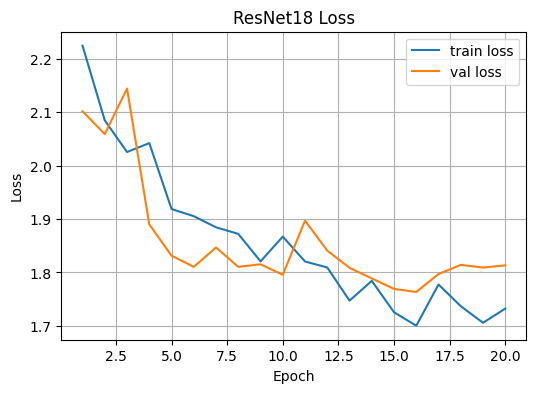

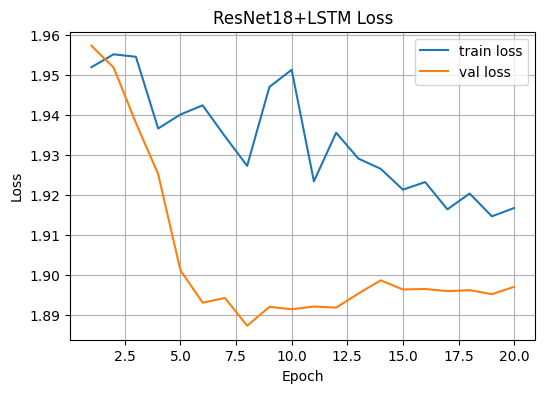

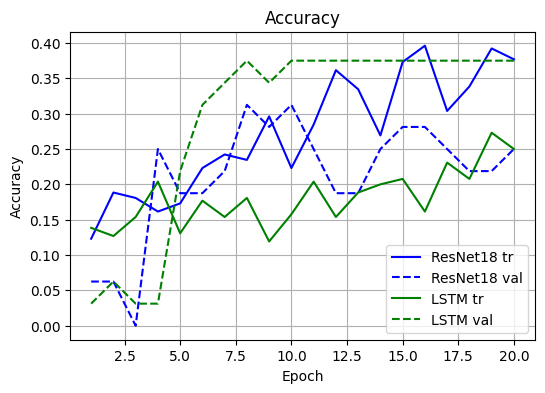

In [23]:
# ============================================================
# CK+ DVS → Fine‑tuned ResNet18 & LSTM with OneCycleLR & Augmentations
# ============================================================

# ─── 0) CONFIG ─────────────────────────────────────────────
CSV_PATH     = "/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
IMG_PATTERN  = "dvs_frame_*.png"
BATCH_SIZE   = 32
SEQ_LEN      = 20
EPOCHS       = 20
LR           = 1e-3               # peak LR for OneCycleLR
VAL_SPLIT    = 0.1
WEIGHT_DECAY = 1e-5
NUM_WORKERS  = 4

import os, glob, random, cv2
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ─── 1) LOAD & FILTER CSV ───────────────────────────────────
df = pd.read_csv(CSV_PATH)
if "events_folder" not in df.columns and "events" in df.columns:
    df = df.rename(columns={"events":"events_folder"})

def count_frames(folder):
    pngs = glob.glob(os.path.join(folder, IMG_PATTERN))
    if pngs: return len(pngs)
    avi = os.path.join(folder, "dvs-video.avi")
    if os.path.isfile(avi):
        cap = cv2.VideoCapture(avi)
        cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return cnt
    return 0

df["nframes"] = df["events_folder"].apply(count_frames)
df = df[df["nframes"]>0].reset_index(drop=True)
print(f"Kept {len(df)} sequences with ≥1 frame")

# ─── 2) SPLIT ───────────────────────────────────────────────
random.seed(0); torch.manual_seed(0)
n = len(df); n_val = int(n * VAL_SPLIT)
perm = np.random.permutation(n)
idx_tr, idx_val, idx_te = perm[n_val*2:], perm[:n_val], perm[n_val:n_val*2]
train_df, val_df, test_df = df.iloc[idx_tr], df.iloc[idx_val], df.iloc[idx_te]

# ─── 3) DATASET CLASS ──────────────────────────────────────
class DVSSequenceDataset(Dataset):
    def __init__(self, df, max_frames, pattern, tfm, mode="single"):
        self.df = df.reset_index(drop=True)
        self.max_frames, self.pattern = max_frames, pattern
        self.tf, self.mode = tfm, mode
        self.lbl2id = {l:i for i,l in enumerate(sorted(df["emotion"].unique()))}
    def __len__(self): return len(self.df)
    def _load_frames(self, folder):
        pngs = sorted(glob.glob(os.path.join(folder, self.pattern)))
        if pngs:
            return [Image.open(p).convert("L") for p in pngs]
        imgs, cap = [], cv2.VideoCapture(os.path.join(folder, "dvs-video.avi"))
        ret, frame = cap.read()
        while ret:
            imgs.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)))
            ret, frame = cap.read()
        cap.release()
        return imgs
    def __getitem__(self, idx):
        row    = self.df.iloc[idx]
        frames = self._load_frames(row.events_folder)
        if self.mode=="single":
            densest = max(frames, key=lambda im: np.array(im).sum())
            return self.tf(densest), self.lbl2id[row.emotion]
        # sequence mode
        frames = frames[:self.max_frames]
        while len(frames) < self.max_frames:
            frames.append(frames[-1])
        seq = torch.stack([self.tf(f) for f in frames])
        return seq, self.lbl2id[row.emotion]

# ─── 4) AUGMENTED TRANSFORMS ───────────────────────────────
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5)
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# ─── 5) DATALOADERS & SAMPLER ─────────────────────────────
counts         = train_df['emotion'].value_counts().sort_index()
class_weights  = 1.0 / counts
sample_weights = train_df['emotion'].map(class_weights).values
sampler        = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

single_train = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf, "single")
single_val   = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,   "single")
single_test  = DVSSequenceDataset(test_df,  SEQ_LEN, IMG_PATTERN, val_tf,   "single")
seq_train    = DVSSequenceDataset(train_df, SEQ_LEN, IMG_PATTERN, train_tf, "sequence")
seq_val      = DVSSequenceDataset(val_df,   SEQ_LEN, IMG_PATTERN, val_tf,   "sequence")

single_loader = {
    "train": DataLoader(single_train, BATCH_SIZE, sampler=sampler,                num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(single_val,   BATCH_SIZE, shuffle=False,                 num_workers=NUM_WORKERS, pin_memory=True)
}
seq_loader = {
    "train": DataLoader(seq_train,    BATCH_SIZE, sampler=sampler,                num_workers=NUM_WORKERS, pin_memory=True),
    "val":   DataLoader(seq_val,      BATCH_SIZE, shuffle=False,                 num_workers=NUM_WORKERS, pin_memory=True)
}

# ─── 6) BACKBONE & MODELS ─────────────────────────────────
res = models.resnet18(pretrained=True)
w   = res.conv1.weight.data
res.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
res.conv1.weight.data = w.mean(1, keepdim=True)
res.fc = nn.Linear(res.fc.in_features, len(single_train.lbl2id))
model_s = res.to(device)

class ResLSTM(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        trunk = nn.Sequential(*list(backbone.children())[:-1])
        self.trunk = trunk
        self.lstm  = nn.LSTM(512, 256, batch_first=True)
        self.head  = nn.Linear(256, num_classes)
    def forward(self, x):
        B, T = x.shape[:2]
        feats = self.trunk(x.view(B*T, 1, 224, 224)).view(B, T, -1)
        _, (h, _) = self.lstm(feats)
        return self.head(h.squeeze(0))

model_seq = ResLSTM(res, len(seq_train.lbl2id)).to(device)

# ─── 7) OPTIMIZER, SCHEDULER & LOSS ────────────────────────
opt_s   = torch.optim.SGD(model_s.parameters(),   lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
opt_seq = torch.optim.SGD(model_seq.parameters(), lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
total_steps = len(single_loader["train"]) * EPOCHS
sched_s   = torch.optim.lr_scheduler.OneCycleLR(opt_s,   max_lr=LR, total_steps=total_steps)
sched_seq = torch.optim.lr_scheduler.OneCycleLR(opt_seq, max_lr=LR, total_steps=total_steps)
crit      = nn.CrossEntropyLoss(label_smoothing=0.1)

# ─── 8) TRAIN/VALIDATE FUNCTION (fixed) ──────────────────
def train_model(model, loaders, optimizer, scheduler, name):
    history = {"epoch":[], "tr_loss":[], "tr_acc":[], "val_loss":[], "val_acc":[]}
    for ep in range(1, EPOCHS+1):
        for phase in ("train","val"):
            if phase=="train":
                model.train()
            else:
                model.eval()

            rl = rc = tot = 0
            with torch.set_grad_enabled(phase=="train"):
                for X, y in loaders[phase]:
                    X, y = X.to(device), y.to(device)
                    if phase=="train":
                        optimizer.zero_grad()
                    out  = model(X)
                    loss = crit(out, y)
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                    preds = out.argmax(1)
                    rl  += loss.item() * y.size(0)
                    rc  += (preds == y).sum().item()
                    tot += y.size(0)

            key = "tr" if phase=="train" else "val"
            history[f"{key}_loss"].append(rl/tot)
            history[f"{key}_acc"].append(rc/tot)

        history["epoch"].append(ep)
        print(f"[{name}] Ep {ep}/{EPOCHS} — tr_acc {history['tr_acc'][-1]:.3f}  val_acc {history['val_acc'][-1]:.3f}")

    return history

# ─── 9) RUN TRAINING ───────────────────────────────────────
hist_s   = train_model(model_s,   single_loader, opt_s,   sched_s,   "ResNet18")
hist_seq = train_model(model_seq,  seq_loader,    opt_seq, sched_seq, "ResNet18+LSTM")

# ─── 10) EVALUATION & METRICS ──────────────────────────────
def evaluate(model, dataset):
    model.eval()
    yt = []; yp = []
    loader = DataLoader(dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    with torch.no_grad():
        for X, y in loader:
            out = model(X.to(device))
            yt.extend(y.tolist())
            yp.extend(out.argmax(1).cpu().tolist())
    acc    = accuracy_score(yt, yp)
    prec, rec, f1, _ = precision_recall_fscore_support(yt, yp, average="weighted", zero_division=0)
    return acc, prec, rec, f1

m_s   = evaluate(model_s,  single_test)
m_seq = evaluate(model_seq, seq_test)
print(f"\nResNet18 single — acc {m_s[0]:.3f}  prec {m_s[1]:.3f}  rec {m_s[2]:.3f}  f1 {m_s[3]:.3f}")
print(f"ResNet18+LSTM — acc {m_seq[0]:.3f}  prec {m_seq[1]:.3f}  rec {m_seq[2]:.3f}  f1 {m_seq[3]:.3f}")

# ─── 11) PLOT TRAIN/VAL CURVES ──────────────────────────────
def plot_curves(h, title):
    plt.figure(figsize=(6,4))
    plt.plot(h["epoch"], h["tr_loss"], label="train loss")
    plt.plot(h["epoch"], h["val_loss"], label="val loss")
    plt.title(f"{title} Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True); plt.show()

plot_curves(hist_s,   "ResNet18")
plot_curves(hist_seq, "ResNet18+LSTM")

plt.figure(figsize=(6,4))
plt.plot(hist_s["epoch"],   hist_s["tr_acc"],   "b-",  label="ResNet18 tr")
plt.plot(hist_s["epoch"],   hist_s["val_acc"],  "b--", label="ResNet18 val")
plt.plot(hist_seq["epoch"], hist_seq["tr_acc"], "g-",  label="LSTM tr")
plt.plot(hist_seq["epoch"], hist_seq["val_acc"],"g--", label="LSTM val")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.show()


In [9]:
# CK+ DVS → AsyNet‑II Sparse Backbone Training & Evaluation on Kaggle
# ============================================================

"""
Environment setup (if using conda shell outside Kaggle):
  conda create -n asynet python=3.7
  conda activate asynet
"""

# ─── 0) CLONE & INSTALL ASYNET‑II DEPENDENCIES ─────────────
# Run this cell first in your Kaggle notebook

# 1) Clone the AsyNet‑II repository via SSH
if not os.path.isdir('rpg_asynet'):
    get_ipython().system('git clone git@github.com:uzh-rpg/rpg_asynet.git')
# Enter the directory
get_ipython().system('cd rpg_asynet')




In [17]:
#get_ipython().system('pip install -q \
 # absl-py==0.9.0 backcall==0.1.0 cachetools==4.0.0 certifi==2019.11.28 chardet==3.0.4 cycler==0.10.0 data==0.4 decorator==4.4.1 funcsigs==1.0.2 future==0.18.2 google-auth==1.11.0 google-auth-oauthlib==0.4.1 grpcio==1.26.0 idna==2.8 ipython==7.13.0 ipython-genutils==0.2.0 jedi==0.16.0 kiwisolver==1.1.0 line-profiler==3.0.2 Markdown==3.2 matplotlib==3.1.3 numpy==1.18.1 oauthlib==3.1.0 opencv-python==4.2.0.32 parso==0.6.2 pexpect==4.8.0 pickleshare==0.7.5 Pillow==8.1.2 prompt-toolkit==3.0.3 protobuf==3.11.3 ptyprocess==0.6.0 pyasn1==0.4.8 pyasn1-modules==0.2.8 pybind11==2.4.3 Pygments==2.5.2 pyparsing==2.4.6 python-dateutil==2.8.1 pytz==2019.3 PyYAML==5.3 requests==2.22.0 requests-oauthlib==1.3.0 shutilwhich==1.1.0 six==1.14.0 snakeviz==2.0.1 tempdir==0.7.1 tensorboard==2.1.0 torch==1.4.0 torchvision==0.5.0 tornado==6.0.3 tqdm==4.42.1 traitlets==4.3.3 urllib3==1.25.8 wcwidth==0.1.8 Werkzeug==1.0.0')
# 2) Install AsyNet‑II Python requirements manually (avoid SSH git URLs)
#    We replace `-r requirements.txt` since it contains git+ssh entries.
get_ipython().system('pip install -q torch torchvision numpy scipy matplotlib pyyaml scikit-learn tqdm')



DEPRECATION: Loading egg at /root/.local/lib/python3.11/site-packages/sparseconvnet-0.2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take 

In [14]:
# 3) Clone and install SparseConvNet v0.2
if not os.path.isdir('SparseConvNet'):
    get_ipython().system('git clone https://github.com/facebookresearch/SparseConvNet.git')
get_ipython().system('cd SparseConvNet && python setup.py install --user && cd ..')




Cloning into 'SparseConvNet'...
remote: Enumerating objects: 1952, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 1952 (delta 39), reused 39 (delta 17), pack-reused 1880 (from 1)
Receiving objects: 100% (1952/1952), 921.93 KiB | 17.39 MiB/s, done.
Resolving deltas: 100% (1388/1388), done.
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils

In [19]:
# 4) Install C++ and Python bindings for event representation tool
get_ipython().system('pip install -q /kaggle/working/rpg_asynet/event_representation_tool/')



DEPRECATION: Loading egg at /root/.local/lib/python3.11/site-packages/sparseconvnet-0.2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Preparing metadata (setup.py) ... done


In [25]:
#if not os.path.isdir('rpg_asynet/async_sparse_py/include/eigen'):
  #  !git clone https://gitlab.com/libeigen/eigen.git rpg_asynet/async_sparse_py/include/eigen


# 6) Install pybind11 via conda-forge (if available) or pip
# conda install -y -c conda-forge pybind11
#get_ipython().system('pip install -q pybind11')

# 7) Install the AsyNet‑II Python package (editable) from the local clone
get_ipython().system('pip install -q -e /kaggle/working/rpg_asynet/async_sparse_py/')

DEPRECATION: Loading egg at /root/.local/lib/python3.11/site-packages/sparseconvnet-0.2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Preparing metadata (setup.py) ... done
    error: subprocess-exited-with-error
    
    × python setup.py develop did not run successfully.
    │ exit code: 1
    ╰─> See above for output.
    
    note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× python setup.py develop did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [29]:
# ─── 1) IMPORTS & CONFIG ────────────────────────────────────
import os, glob, random
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader        # ← ensure Dataset is imported
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Add AsyNet‑II code to path
#sys.path.insert(0, os.path.join(os.getcwd(), 'rpg_asynet'))
# Import SparseVGG and dataset factory
from models.asyn_sparse_vgg import asynSparseVGG
from dataloader.dataset import getDataloader

DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ─── 2) CONFIG ───────────────────────────────────────────────────────────────
BASE_PATH   = "/kaggle/input/ck-v2e-out"
CSV_PATH    = "/kaggle/input/ck-v2e-out/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
IMG_PATTERN = "dvs_frame_*.png"
BATCH_SIZE  = 8
SEQ_LEN     = 20      # not used for SparseVGG (it works on raw events)
EPOCHS      = 20
LR          = 1e-3

# ─── 3) CK+ DATASET ─────────────────────────────────────────────────────────
# ─── 3) CK+ DATASET ─────────────────────────────────────────────────────────
class CKPlusDataset(Dataset):
    def __init__(self, csv_path, root_dir, split_idxs):
        # emotion, sequence, num_frames, events
        df = pd.read_csv(csv_path).reset_index(drop=True)
        # filter to correct split
        self.df = df.loc[split_idxs].reset_index(drop=True)
        self.root = root_dir
        # build a map from emotion string to integer
        emotions = self.df['emotion'].unique().tolist()
        self.lbl2id = {emo:i for i,emo in enumerate(emotions)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # CSV 'events' column has e.g.
        # /kaggle/working/ck_v2e_out/anger/S010_004
        # we need to point into the input dataset:
        folder = row['events'].replace(
            "/kaggle/working/ck_v2e_out", 
            "/kaggle/input/ck-v2e-out"
        )

        # load all dvs frames (same as before)…
        pngs = sorted(glob.glob(os.path.join(folder, IMG_PATTERN)))
        evs  = []
        if pngs:
            for i,p in enumerate(pngs):
                img = np.array(Image.open(p).convert("L"))
                coords = np.column_stack(np.nonzero(img))
                tstamp = np.full((coords.shape[0],1), i, dtype=np.float32)
                pol    = np.where(img[coords[:,0], coords[:,1]]>0, 1.0, -1.0).reshape(-1,1)
                evs.append(np.concatenate([coords[:,1:2], coords[:,0:1], tstamp, pol], axis=1))
            events = np.vstack(evs).astype(np.float32)
        else:
            # fallback to avi
            import cv2
            cap    = cv2.VideoCapture(os.path.join(folder,"dvs-video.avi"))
            frames = []; i = 0
            while True:
                ret, frame = cap.read()
                if not ret: break
                gray  = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                coords = np.column_stack(np.nonzero(gray))
                tstamp = np.full((coords.shape[0],1), i, dtype=np.float32)
                pol    = np.where(gray[coords[:,0], coords[:,1]]>0,1.0,-1.0).reshape(-1,1)
                frames.append(np.concatenate([coords[:,1:2], coords[:,0:1], tstamp, pol], axis=1))
                i += 1
            cap.release()
            events = np.vstack(frames).astype(np.float32)

        label_str = row['emotion']
        label     = self.lbl2id[label_str]
        return torch.from_numpy(events), torch.tensor(label, dtype=torch.long)

# ─── 4) SPLIT & DATALOADERS ─────────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)
n  = len(df)
idx = np.arange(n)
np.random.seed(0); np.random.shuffle(idx)
n_val    = int(0.1 * n)
train_ix = idx[n_val*2:]
val_ix   = idx[:n_val]
test_ix  = idx[n_val:n_val*2]

train_ds = CKPlusDataset(CSV_PATH, BASE_PATH, train_ix)
val_ds   = CKPlusDataset(CSV_PATH, BASE_PATH, val_ix)
test_ds  = CKPlusDataset(CSV_PATH, BASE_PATH, test_ix)

# same collate and DataLoader code as before…
def ck_collate(batch):
    evs, lbs = zip(*batch)
    return torch.cat(evs, dim=0), torch.tensor(lbs, dtype=torch.long)

# ─── 4) SPLIT & DATALOADERS ─────────────────────────────────────────────────
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=ck_collate
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=ck_collate
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=ck_collate
)

# ─── 5) NUM_CLASSES ─────────────────────────────────────────────────────────
num_classes = len(train_ds.lbl2id)   # now uses the emotion map
print("Classes:", train_ds.lbl2id)

# ─── 4) SPLIT INDICES ────────────────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)
n = len(df)
idx = np.arange(n)
np.random.seed(0)
np.random.shuffle(idx)
n_val = int(0.1*n)
train_idx = idx[n_val*2:]
val_idx   = idx[:n_val]
test_idx  = idx[n_val:n_val*2]

# ─── 5) DATALOADERS ─────────────────────────────────────────────────────────
train_ds = CKPlusDataset(CSV_PATH, BASE_PATH, train_idx)
val_ds   = CKPlusDataset(CSV_PATH, BASE_PATH, val_idx)
test_ds  = CKPlusDataset(CSV_PATH, BASE_PATH, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True, collate_fn=lambda b: tuple(torch.cat(x,0) if i==0 else torch.tensor([y for y in b][i]) for i,x in enumerate(zip(*b))))
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, collate_fn=lambda b: tuple(torch.cat(x,0) if i==0 else torch.tensor([y for y in b][i]) for i,x in enumerate(zip(*b))))
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, collate_fn=lambda b: tuple(torch.cat(x,0) if i==0 else torch.tensor([y for y in b][i]) for i,x in enumerate(zip(*b))))

# ─── 6) MODEL & TRAIN SETUP ─────────────────────────────────────────────────
num_classes = len(df.emotion.unique())
model = asynSparseVGG(
    nr_classes     = num_classes,
    input_channels = 2,
    device         = DEVICE
)
# ─── 6) OPTIMIZER & SCHEDULER ───────────────────────────────────────
# collect all trainable params from the asynchronous layers
param_list = []
for layer in model.asyn_layers:
    if hasattr(layer, "parameters"):
        param_list += list(layer.parameters())

opt   = torch.optim.Adam(param_list, lr=LR)
steps = len(train_loader) * EPOCHS
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, total_steps=steps)
crit  = nn.CrossEntropyLoss()

# ─── 7) TRAIN/VAL LOOP ─────────────────────────────────────────────
history = {'epoch':[], 'tr_loss':[], 'tr_acc':[], 'val_loss':[], 'val_acc':[]}

for ep in range(1, EPOCHS+1):
    # ——— training —————————————————————————————————————
    set_asynet_mode(model, True)   # instead of model.train()
    tloss = tcorr = tsamp = 0
    for events, labels in train_loader:
        events, labels = events.to(DEVICE), labels.to(DEVICE)

        upds, fmap = model.generateAsynInput(
            new_batch_events   = events,
            spatial_dimensions = torch.tensor([224,224], device=DEVICE),
            original_shape     = (224,224)
        )
        x_asyn = (upds, fmap)

        out_asyn = model.forward(x_asyn)
        logits   = out_asyn[1].unsqueeze(0)
        loss     = crit(logits, labels.unsqueeze(0))

        opt.zero_grad()
        loss.backward()
        opt.step()
        sched.step()

        preds      = logits.argmax(1)
        tloss  += loss.item() * labels.size(0)
        tcorr  += (preds == labels).sum().item()
        tsamp  += labels.size(0)

    tr_loss, tr_acc = tloss/tsamp, tcorr/tsamp

    # ——— validation ————————————————————————————————————
    set_asynet_mode(model, False)  # instead of model.eval()
    vloss = vcorr = vsamp = 0
    with torch.no_grad():
        for events, labels in val_loader:
            events, labels = events.to(DEVICE), labels.to(DEVICE)

            upds, fmap = model.generateAsynInput(
                new_batch_events   = events,
                spatial_dimensions = torch.tensor([224,224], device=DEVICE),
                original_shape     = (224,224)
            )
            x_asyn = (upds, fmap)

            out_asyn = model.forward(x_asyn)
            logits   = out_asyn[1].unsqueeze(0)
            loss     = crit(logits, labels.unsqueeze(0))

            preds = logits.argmax(1)
            vloss  += loss.item() * labels.size(0)
            vcorr  += (preds == labels).sum().item()
            vsamp  += labels.size(0)

    val_loss, val_acc = vloss/vsamp, vcorr/vsamp

    history['epoch'].append(ep)
    history['tr_loss'].append(tr_loss)
    history['tr_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"[AsyNet‑II] Ep{ep}/{EPOCHS} tr_acc {tr_acc:.3f} val_acc {val_acc:.3f}")


Using device: cuda
Classes: {'sadness': 0, 'happy': 1, 'anger': 2, 'surprise': 3, 'disgust': 4, 'fear': 5, 'contempt': 6}


NameError: name 'set_asynet_mode' is not defined

In [45]:
# ─── 1) IMPORTS & CONFIG ────────────────────────────────────
import os, glob, random
import numpy as np, pandas as pd
# patch deprecated np.int
np.int = int

from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# AsyNet‑II import
import sys
sys.path.insert(0, "/kaggle/working/rpg_asynet")
from models.asyn_sparse_vgg import asynSparseVGG

DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_PATH   = "/kaggle/input/ck-v2e-out"
CSV_PATH    = "/kaggle/input/ck-v2e-out/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
IMG_PATTERN = "dvs_frame_*.png"
BATCH_SIZE  = 8
EPOCHS      = 20
LR          = 1e-5

print("Using device:", DEVICE)

# ─── 2) GLOBAL LABEL MAP ────────────────────────────────────
df_full  = pd.read_csv(CSV_PATH)
emotions = sorted(df_full["emotion"].unique())
lbl2id   = {emo:i for i, emo in enumerate(emotions)}
print("Classes:", lbl2id)

# ─── 3) THE CK+→DVS DATASET ────────────────────────────────
class CKPlusDataset(Dataset):
    def __init__(self, csv_path, base_path, split_idxs, lbl2id):
        df    = pd.read_csv(csv_path).reset_index(drop=True)
        rows  = []
        for i in split_idxs:
            raw    = df.at[i,"events"].lstrip("/")
            folder = os.path.join(base_path, raw)
            if glob.glob(os.path.join(folder, IMG_PATTERN)) \
               or os.path.isfile(os.path.join(folder,"dvs-video.avi")):
                rows.append((i,folder))
        self.rows   = rows
        self.df     = df
        self.lbl2id = lbl2id

    def __len__(self): return len(self.rows)

    def __getitem__(self, idx):
        orig_idx, folder = self.rows[idx]
        evs = []

        # try PNGs
        pngs = sorted(glob.glob(os.path.join(folder, IMG_PATTERN)))
        if pngs:
            for t,p in enumerate(pngs):
                img = np.array(Image.open(p).convert("L"))
                ys,xs = np.nonzero(img)
                if xs.size:
                    ts  = np.full_like(xs, t, dtype=np.float32)
                    pol = np.where(img[ys,xs]>0,1.0,-1.0).astype(np.float32)
                    evs.append(np.stack([xs,ys,ts,pol],axis=1))
        else:
            # fallback to AVI
            import cv2
            cap = cv2.VideoCapture(os.path.join(folder,"dvs-video.avi"))
            t = 0
            while True:
                ret,fr = cap.read()
                if not ret: break
                gray = cv2.cvtColor(fr,cv2.COLOR_BGR2GRAY)
                ys,xs = np.nonzero(gray)
                if xs.size:
                    ts  = np.full_like(xs,t,dtype=np.float32)
                    pol = np.where(gray[ys,xs]>0,1.0,-1.0).astype(np.float32)
                    evs.append(np.stack([xs,ys,ts,pol],axis=1))
                t+=1
            cap.release()

        if not evs:
            evs = [np.zeros((1,4),dtype=np.float32)]

        events = torch.from_numpy(np.vstack(evs).astype(np.float32))
        label  = torch.tensor(self.lbl2id[self.df.at[orig_idx,"emotion"]],
                              dtype=torch.long)
        return events, label

# ─── 4) SPLIT & DATALOADERS ────────────────────────────────
n       = len(df_full)
idxs    = np.arange(n)
np.random.seed(0); np.random.shuffle(idxs)
n_val   = int(0.1 * n)
train_i = idxs[n_val*2:]
val_i   = idxs[:n_val]
test_i  = idxs[n_val:n_val*2]

train_ds = CKPlusDataset(CSV_PATH, BASE_PATH, train_i, lbl2id)
val_ds   = CKPlusDataset(CSV_PATH, BASE_PATH, val_i,   lbl2id)
test_ds  = CKPlusDataset(CSV_PATH, BASE_PATH, test_i,  lbl2id)
print("Dataset sizes:", len(train_ds), len(val_ds), len(test_ds))

def ck_collate(batch):
    evs, lbs = zip(*batch)
    return torch.cat(evs,0), torch.stack(lbs)

train_loader = DataLoader(train_ds,  batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True,
                          collate_fn=ck_collate)
val_loader   = DataLoader(val_ds,    batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True,
                          collate_fn=ck_collate)
test_loader  = DataLoader(test_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True,
                          collate_fn=ck_collate)

# ─── 5) MODEL, OPT & SCHEDULER ─────────────────────────────
model = asynSparseVGG(nr_classes=len(emotions),
                      input_channels=2,
                      device=DEVICE)

# collect only the sparse‐conv params
params = []
for L in model.asyn_layers:
    if hasattr(L, "parameters"):
        params += list(L.parameters())

opt   = torch.optim.Adam(params, lr=LR)
steps = len(train_loader) * EPOCHS
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, total_steps=steps)
crit  = nn.CrossEntropyLoss()

def set_asynet_mode(net, train_mode:bool):
    for L in net.asyn_layers:
        if hasattr(L, "train"):
            L.train(train_mode)

# ─── safe_forward HELPER ───────────────────────────────────
def safe_forward(model, ups, fm):
    """
    Wraps model.forward((ups,fm)).
    On that device‐mismatch error, retries on CPU then moves back to DEVICE.
    """
    try:
        return model.forward((ups,fm))
    except RuntimeError as err:
        msg = str(err)
        if "indices should be either on cpu" in msg:
            # retry on CPU
            ups_c = ups.cpu()
            fm_c  = fm.cpu()
            out_c = model.forward((ups_c,fm_c))
            return (out_c[0].to(DEVICE), out_c[1].to(DEVICE))
        else:
            raise




Using device: cuda
Classes: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}
Dataset sizes: 263 32 32


In [59]:
# ─── 0) Install / Imports ─────────────────────────────────────────
# !pip install torch torchvision  # if not already installed

import os, glob
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# ─── 1) CONFIGURATION ─────────────────────────────────────────────
BASE_PATH = "/kaggle/input/ck-v2e-out"
CSV_PATH  = os.path.join(BASE_PATH, "kaggle/working/ck_v2e_out/ck_v2e_summary.csv")
BATCH_SIZE = 2
EPOCHS     = 20
LR         = 1e-5
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_BINS = 5               # # time‐slices
HEIGHT   = 180             # DVS sensor height
WIDTH    = 240             # DVS sensor width

print("Using device:", DEVICE)

# ─── 2) DATASET ───────────────────────────────────────────────────
class CKPlusVoxelDataset(Dataset):
    def __init__(self, csv_path, base_path, split_idxs, lbl2id,
                 num_bins=8, H=180, W=240, img_pattern="dvs_frame_*.png"):
        df = pd.read_csv(csv_path).reset_index(drop=True)
        self.df      = df.loc[split_idxs].reset_index(drop=True)
        self.base    = base_path
        self.lbl2id  = lbl2id
        self.num_bins = num_bins
        self.H, self.W = H, W
        self.img_pattern = img_pattern

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        rel = r["events"].lstrip("/")                    # "/anger/S011_004"
        folder = os.path.join(self.base, rel)             # .../ck-v2e-out/anger/S011_004

        # 1) Load per‐pixel events from PNGs (or AVI fallback)
        arrs = []
        pngs = sorted(glob.glob(os.path.join(folder, self.img_pattern)))
        if pngs:
            for t,p in enumerate(pngs):
                im = np.array(Image.open(p).convert("L"))
                ys,xs = np.nonzero(im)
                if xs.size:
                    ts  = np.full_like(xs, t, dtype=np.int64)
                    pol = (im[ys,xs] > 0).astype(np.int64)
                    arrs.append(np.stack([xs, ys, ts, pol], axis=1))
        else:
            import cv2
            cap = cv2.VideoCapture(os.path.join(folder,"dvs-video.avi"))
            t = 0
            while True:
                ret,frame = cap.read()
                if not ret: break
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                ys,xs = np.nonzero(gray)
                if xs.size:
                    ts  = np.full_like(xs, t, dtype=np.int64)
                    pol = (gray[ys,xs] > 0).astype(np.int64)
                    arrs.append(np.stack([xs, ys, ts, pol], axis=1))
                t += 1
            cap.release()

        if not arrs:
            arrs = [np.zeros((1,4),dtype=np.int64)]
        ev = np.vstack(arrs)  # shape (N_events,4)

        # 2) Bin into a (B,2,H,W) “voxel grid”
        voxel = np.zeros((self.num_bins, 2, self.H, self.W), dtype=np.float32)
        max_t = int(ev[:,2].max()) + 1
        edges = np.linspace(0, max_t, self.num_bins+1)
        for x,y,t,pol in ev:
            b = np.searchsorted(edges, t, side="right") - 1
            b = int(np.clip(b, 0, self.num_bins-1))
            voxel[b, pol, y, x] += 1.0

        voxel = torch.from_numpy(voxel)  # (B,2,H,W)
        lbl   = torch.tensor(self.lbl2id[r["emotion"]], dtype=torch.long)
        return voxel, lbl

# ─── 3) SPLIT & DATALOADERS ────────────────────────────────────────
df_full  = pd.read_csv(CSV_PATH)
emotions = sorted(df_full["emotion"].unique())
lbl2id   = {emo:i for i,emo in enumerate(emotions)}

n  = len(df_full)
idx = np.arange(n)
np.random.seed(0); np.random.shuffle(idx)
n_val = int(0.1 * n)
train_idx = idx[n_val*2:]
val_idx   = idx[:n_val]
test_idx  = idx[n_val:n_val*2]

train_ds = CKPlusVoxelDataset(CSV_PATH, BASE_PATH, train_idx, lbl2id,
                              num_bins=NUM_BINS, H=HEIGHT, W=WIDTH)
val_ds   = CKPlusVoxelDataset(CSV_PATH, BASE_PATH, val_idx,   lbl2id,
                              num_bins=NUM_BINS, H=HEIGHT, W=WIDTH)
test_ds  = CKPlusVoxelDataset(CSV_PATH, BASE_PATH, test_idx,  lbl2id,
                              num_bins=NUM_BINS, H=HEIGHT, W=WIDTH)

print("Dataset sizes:", len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)

# ─── 4) MODEL DEFINITION ───────────────────────────────────────────
class ResNetTransformer(nn.Module):
    def __init__(self, num_classes, num_bins):
        super().__init__()
        # 1) Pretrained ResNet50 as spatial feature extractor
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # adapt first conv to 2 channels (polarity)
        resnet.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # drop original fc
        resnet.fc = nn.Identity()
        self.backbone = resnet
        d_model = 2048

        # 2) simple learnable positional‐encoding over time bins
        self.pos_embed   = nn.Parameter(torch.zeros(1, num_bins, d_model))

        # 3) Transformer Encoder
        encoder_layer   = TransformerEncoderLayer(
            d_model=d_model, nhead=8, dim_feedforward=2048, dropout=0.1
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=2)

        # 4) final classification head
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, K, 2, H, W]
        B, K, C, H, W = x.shape
        x = x.view(B*K, C, H, W)              # [B*K,2,H,W]
        feat = self.backbone(x)               # [B*K,2048]
        feat = feat.view(B, K, -1)            # [B,K,2048]
        feat = feat + self.pos_embed          # add pos‐enc
        t = feat.permute(1,0,2)               # [K,B,2048]
        out = self.transformer(t)             # [K,B,2048]
        out = out.mean(dim=0)                 # global‐pool over time → [B,2048]
        logits = self.classifier(out)         # [B,num_classes]
        return logits

# ─── 5) INSTANTIATE & OPTIMIZER ──────────────────────────────────
model = ResNetTransformer(num_classes=len(emotions), num_bins=NUM_BINS)
model = model.to(DEVICE)

opt   = torch.optim.Adam(model.parameters(), lr=LR)
steps = len(train_loader) * EPOCHS
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, total_steps=steps)
crit  = nn.CrossEntropyLoss()

# ─── 6) TRAIN & VALIDATE ────────────────────────────────────────
history = {'epoch':[], 'tr_loss':[], 'tr_acc':[], 'val_loss':[], 'val_acc':[]}

for ep in range(1, EPOCHS+1):
    # ——— train —————————————————————————————————————————
    model.train()
    running_loss = running_corr = running_n = 0
    for vox, lbl in train_loader:
        vox, lbl = vox.to(DEVICE), lbl.to(DEVICE)
        logits   = model(vox)
        loss     = crit(logits, lbl)
        opt.zero_grad(); loss.backward(); opt.step(); sched.step()

        preds = logits.argmax(dim=1)
        running_loss += loss.item() * lbl.size(0)
        running_corr += (preds==lbl).sum().item()
        running_n    += lbl.size(0)

    tr_loss = running_loss / running_n
    tr_acc  = running_corr  / running_n

    # ——— validate —————————————————————————————————————
    model.eval()
    val_loss = val_corr = val_n = 0
    with torch.no_grad():
        for vox, lbl in val_loader:
            vox, lbl = vox.to(DEVICE), lbl.to(DEVICE)
            logits   = model(vox)
            loss     = crit(logits, lbl)
            preds    = logits.argmax(dim=1)
            val_loss += loss.item() * lbl.size(0)
            val_corr += (preds==lbl).sum().item()
            val_n    += lbl.size(0)

    val_loss = val_loss / val_n
    val_acc  = val_corr  / val_n

    history['epoch'].append(ep)
    history['tr_loss'].append(tr_loss)
    history['tr_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"[Epoch {ep}/{EPOCHS}]  tr_loss {tr_loss:.4f} tr_acc {tr_acc:.4f}  "
          f"val_loss {val_loss:.4f} val_acc {val_acc:.4f}")

# ─── 7) TEST & METRICS ────────────────────────────────────────
model.eval()
y_true = []; y_pred = []
with torch.no_grad():
    for vox, lbl in test_loader:
        vox, lbl = vox.to(DEVICE), lbl.to(DEVICE)
        logits   = model(vox)
        preds    = logits.argmax(dim=1)
        y_true.extend(lbl.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

# compute accuracy + precision/recall/f1
acc  = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)
print(f"\nTest — acc {acc:.4f}  prec {prec:.4f}  rec {rec:.4f}  f1 {f1:.4f}")

# ─── 8) PLOT METRICS ─────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(history['epoch'], history['tr_loss'], label='train loss')
plt.plot(history['epoch'], history['val_loss'], label='val loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history['epoch'], history['tr_acc'], label='train acc')
plt.plot(history['epoch'], history['val_acc'], label='val acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True); plt.show()


Using device: cuda
Dataset sizes: 263 32 32


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Epoch 1/20]  tr_loss 1.9065 tr_acc 0.2471  val_loss 1.9976 val_acc 0.1562
[Epoch 2/20]  tr_loss 1.7803 tr_acc 0.3042  val_loss 2.2291 val_acc 0.1562
[Epoch 3/20]  tr_loss 1.7904 tr_acc 0.3308  val_loss 2.3760 val_acc 0.1562
[Epoch 4/20]  tr_loss 1.8822 tr_acc 0.3460  val_loss 2.3102 val_acc 0.3750
[Epoch 5/20]  tr_loss 1.8854 tr_acc 0.3460  val_loss 3.0288 val_acc 0.3125
[Epoch 6/20]  tr_loss 1.8022 tr_acc 0.3612  val_loss 3.8729 val_acc 0.3125
[Epoch 7/20]  tr_loss 1.7552 tr_acc 0.4144  val_loss 2.1565 val_acc 0.2188
[Epoch 8/20]  tr_loss 1.4767 tr_acc 0.4373  val_loss 2.1658 val_acc 0.2500
[Epoch 9/20]  tr_loss 1.3840 tr_acc 0.5399  val_loss 1.9894 val_acc 0.4375
[Epoch 10/20]  tr_loss 1.4253 tr_acc 0.4981  val_loss 1.8483 val_acc 0.4062
[Epoch 11/20]  tr_loss 0.9815 tr_acc 0.6350  val_loss 3.9274 val_acc 0.1875
[Epoch 12/20]  tr_loss 0.9661 tr_acc 0.6730  val_loss 2.4087 val_acc 0.4375
[Epoch 13/20]  tr_loss 0.8924 tr_acc 0.7034  val_loss 2.7422 val_acc 0.3750
[Epoch 14/20]  tr_los

In [63]:
# ─── 0) Install / Imports ─────────────────────────────────────────
# !pip install torch torchvision  # if not already installed

import os, glob
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# ─── 1) CONFIGURATION ─────────────────────────────────────────────
BASE_PATH = "/kaggle/input/ck-v2e-out"
CSV_PATH  = os.path.join(BASE_PATH, "kaggle/working/ck_v2e_out/ck_v2e_summary.csv")
BATCH_SIZE = 32
EPOCHS     = 20
LR         = 1e-5
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_BINS = 5               # time‐slices
HEIGHT   = 180             # DVS sensor height
WIDTH    = 240             # DVS sensor width

print("Using device:", DEVICE)

# ─── 2) DATASET ───────────────────────────────────────────────────
class CKPlusVoxelDataset(Dataset):
    def __init__(self, csv_path, base_path, split_idxs, lbl2id,
                 num_bins=5, H=180, W=240, img_pattern="dvs_frame_*.png"):
        df = pd.read_csv(csv_path).reset_index(drop=True)
        self.df       = df.loc[split_idxs].reset_index(drop=True)
        self.base     = base_path
        self.lbl2id   = lbl2id
        self.num_bins = num_bins
        self.H, self.W = H, W
        self.img_pattern = img_pattern

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r    = self.df.iloc[idx]
        rel  = r["events"].lstrip("/")
        folder = os.path.join(self.base, rel)

        # 1) load raw events
        arrs = []
        pngs = sorted(glob.glob(os.path.join(folder, self.img_pattern)))
        if pngs:
            for t,p in enumerate(pngs):
                im = np.array(Image.open(p).convert("L"))
                ys,xs = np.nonzero(im)
                if xs.size:
                    ts  = np.full_like(xs, t, dtype=np.int64)
                    pol = (im[ys,xs]>0).astype(np.int64)
                    arrs.append(np.stack([xs,ys,ts,pol],axis=1))
        else:
            import cv2
            cap = cv2.VideoCapture(os.path.join(folder,"dvs-video.avi"))
            t=0
            while True:
                ret,frame = cap.read()
                if not ret: break
                gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                ys,xs = np.nonzero(gray)
                if xs.size:
                    ts  = np.full_like(xs, t, dtype=np.int64)
                    pol = (gray[ys,xs]>0).astype(np.int64)
                    arrs.append(np.stack([xs,ys,ts,pol],axis=1))
                t+=1
            cap.release()

        if not arrs:
            arrs = [np.zeros((1,4),dtype=np.int64)]
        ev = np.vstack(arrs)

        # 2) bin into voxel grid
        voxel = np.zeros((self.num_bins, 2, self.H, self.W),dtype=np.float32)
        max_t = int(ev[:,2].max())+1
        edges = np.linspace(0, max_t, self.num_bins+1)
        for x,y,t,pol in ev:
            b = np.clip(np.searchsorted(edges,t,side="right")-1,0,self.num_bins-1)
            voxel[b,pol,y,x] += 1.0

        return (torch.from_numpy(voxel),
                torch.tensor(self.lbl2id[r["emotion"]],dtype=torch.long))

# ─── 3) SPLIT & LOADERS ───────────────────────────────────────────
df_full  = pd.read_csv(CSV_PATH)
emotions = sorted(df_full["emotion"].unique())
lbl2id   = {emo:i for i,emo in enumerate(emotions)}

n   = len(df_full)
idx = np.arange(n)
np.random.seed(0); np.random.shuffle(idx)

n_test = int(0.05*n)
n_val  = int(0.20*n)

test_idx  = idx[:n_test]
val_idx   = idx[n_test:n_test+n_val]
train_idx = idx[n_test+n_val:]

print(f"Splits → train {len(train_idx)},  val {len(val_idx)},  test {len(test_idx)}")

train_ds = CKPlusVoxelDataset(CSV_PATH, BASE_PATH, train_idx, lbl2id,
                              num_bins=NUM_BINS, H=HEIGHT, W=WIDTH)
val_ds   = CKPlusVoxelDataset(CSV_PATH, BASE_PATH, val_idx,   lbl2id,
                              num_bins=NUM_BINS, H=HEIGHT, W=WIDTH)
test_ds  = CKPlusVoxelDataset(CSV_PATH, BASE_PATH, test_idx,  lbl2id,
                              num_bins=NUM_BINS, H=HEIGHT, W=WIDTH)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)

# ─── 4) MODEL DEFINITION ───────────────────────────────────────────
class ResNet18Transformer(nn.Module):
    def __init__(self, num_classes, num_bins):
        super().__init__()
        # use a small ResNet‑18 backbone
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        resnet.conv1 = nn.Conv2d(2,64,7,2,3,bias=False)
        resnet.fc    = nn.Identity()
        self.backbone = resnet

        d_model = 512
        self.pos_embed = nn.Parameter(torch.zeros(1, num_bins, d_model))

        # just one Transformer layer
        enc_layer = TransformerEncoderLayer(d_model, nhead=4,
                                            dim_feedforward=1024,
                                            dropout=0.1)
        self.transformer = TransformerEncoder(enc_layer, num_layers=1)

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(0.2),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: [B,K,2,H,W]
        B,K,C,H,W = x.shape
        x = x.view(B*K, C, H, W)             # [B*K,2,H,W]
        feat = self.backbone(x)              # [B*K,512]
        feat = feat.view(B, K, -1)           # [B,K,512]
        feat = feat + self.pos_embed         # [1,K,512] broadcast
        t    = feat.permute(1,0,2)           # [K,B,512]
        y    = self.transformer(t)           # [K,B,512]
        y    = y.mean(dim=0)                 # [B,512]
        return self.classifier(y)            # [B,num_classes]

# ─── 5) INSTANTIATE & OPTIMIZER ──────────────────────────────────
model = ResNet18Transformer(num_classes=len(emotions), num_bins=NUM_BINS).to(DEVICE)

opt   = torch.optim.Adam(model.parameters(), lr=LR)
steps = len(train_loader)*EPOCHS
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, total_steps=steps)
crit  = nn.CrossEntropyLoss()

# ─── 6) TRAIN & VALIDATE ────────────────────────────────────────
history = {'epoch':[], 'tr_loss':[], 'tr_acc':[], 'val_loss':[], 'val_acc':[]}
for ep in range(1, EPOCHS+1):
    # training
    model.train()
    running_loss=running_corr=running_n=0
    for vox,lbl in train_loader:
        vox,lbl = vox.to(DEVICE), lbl.to(DEVICE)
        logits  = model(vox)
        loss    = crit(logits,lbl)
        opt.zero_grad(); loss.backward(); opt.step(); sched.step()

        preds = logits.argmax(dim=1)
        running_loss += loss.item()*lbl.size(0)
        running_corr += (preds==lbl).sum().item()
        running_n    += lbl.size(0)
    tr_loss, tr_acc = running_loss/running_n, running_corr/running_n

    # validation
    model.eval()
    v_loss=v_corr=v_n=0
    with torch.no_grad():
        for vox,lbl in val_loader:
            vox,lbl = vox.to(DEVICE), lbl.to(DEVICE)
            logits  = model(vox)
            loss    = crit(logits,lbl)
            preds   = logits.argmax(dim=1)
            v_loss += loss.item()*lbl.size(0)
            v_corr += (preds==lbl).sum().item()
            v_n    += lbl.size(0)
    val_loss, val_acc = v_loss/v_n, v_corr/v_n

    history['epoch'].append(ep)
    history['tr_loss'].append(tr_loss)
    history['tr_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"[Epoch {ep}/{EPOCHS}]  tr_loss {tr_loss:.4f} tr_acc {tr_acc:.4f}  "
          f"val_loss {val_loss:.4f} val_acc {val_acc:.4f}")

# ─── 7) TEST & METRICS ────────────────────────────────────────
model.eval()
y_true=[]; y_pred=[]
with torch.no_grad():
    for vox,lbl in test_loader:
        vox    = vox.to(DEVICE)
        preds  = model(vox).argmax(dim=1)
        y_true.extend(lbl.tolist())
        y_pred.extend(preds.cpu().tolist())

acc  = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)
print(f"\nTest → acc {acc:.4f}  prec {prec:.4f}  rec {rec:.4f}  f1 {f1:.4f}")

# ─── 8) PLOT METRICS ─────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(history['epoch'], history['tr_loss'], label='train loss')
plt.plot(history['epoch'], history['val_loss'], label='val loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history['epoch'], history['tr_acc'], label='train acc')
plt.plot(history['epoch'], history['val_acc'], label='val acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True); plt.show()


Using device: cuda
Splits → train 246,  val 65,  test 16


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Epoch 1/20]  tr_loss 2.2894 tr_acc 0.0569  val_loss 2.1437 val_acc 0.0769
[Epoch 2/20]  tr_loss 2.1737 tr_acc 0.0935  val_loss 1.9670 val_acc 0.1692
[Epoch 3/20]  tr_loss 1.9986 tr_acc 0.1667  val_loss 2.1337 val_acc 0.0769
[Epoch 4/20]  tr_loss 1.8331 tr_acc 0.2886  val_loss 2.0834 val_acc 0.0923
[Epoch 5/20]  tr_loss 1.7395 tr_acc 0.3415  val_loss 2.0542 val_acc 0.0615
[Epoch 6/20]  tr_loss 1.6770 tr_acc 0.3659  val_loss 2.0590 val_acc 0.0769
[Epoch 7/20]  tr_loss 1.6399 tr_acc 0.3618  val_loss 2.1239 val_acc 0.0615
[Epoch 8/20]  tr_loss 1.5445 tr_acc 0.4187  val_loss 2.1440 val_acc 0.0615
[Epoch 9/20]  tr_loss 1.5357 tr_acc 0.4268  val_loss 2.1142 val_acc 0.0615
[Epoch 10/20]  tr_loss 1.4637 tr_acc 0.4715  val_loss 2.0236 val_acc 0.1077
[Epoch 11/20]  tr_loss 1.4437 tr_acc 0.4797  val_loss 2.0052 val_acc 0.2154
[Epoch 12/20]  tr_loss 1.3774 tr_acc 0.4878  val_loss 2.0632 val_acc 0.2308
[Epoch 13/20]  tr_loss 1.3488 tr_acc 0.4797  val_loss 1.9213 val_acc 0.2154
[Epoch 14/20]  tr_los

In [2]:
# ─── 0) Imports & Config ───────────────────────────────────────
import os, glob
import numpy as np
import pandas as pd
from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH     = 8
EPOCHS    = 20
LR        = 1e-4
NUM_BINS  = 5
H, W      = 180, 240
PATTERN   = "dvs_frame_*.png"

# ─── 1) Build a single dataframe for BOTH datasets ───────────────
# 1a) CK+ DVS
ck_csv   = "/kaggle/input/ck-v2e-out/kaggle/working/ck_v2e_out/ck_v2e_summary.csv"
ck_base  = "/kaggle/input/ck-v2e-out"
ck_df    = pd.read_csv(ck_csv).reset_index(drop=True)
ck_df["folder"] = ck_df["events"].str.lstrip("/").apply(lambda r: os.path.join(ck_base, r))
ck_df["source"] = "ck"

# 1b) NEFER DVS
nf_csv   = "/kaggle/input/nefer-v2e/v2e_event_labels.csv"      # <— wherever your NEFER manifest is
nf_base  = "/kaggle/input/nefer-v2e/kaggle/working/v2e_output"
nf_df    = pd.read_csv(nf_csv).reset_index(drop=True)
nf_df["folder"] = nf_df["events"].str.lstrip("/").apply(lambda r: os.path.join(nf_base, r))
nf_df["source"] = "nefer"

# 1c) unify emotion→int mapping over both
all_emotions = sorted(set(ck_df["emotion"].unique()) 
                      | set(nf_df["emotion"].unique()))
lbl2id       = {emo:i for i,emo in enumerate(all_emotions)}

# 1d) combine & keep only folders that actually exist
full = pd.concat([ck_df, nf_df], ignore_index=True)
full["label"] = full["emotion"].map(lbl2id)
# drop any row where neither PNGs nor AVI exist
def has_data(f):
    return bool(glob.glob(os.path.join(f, PATTERN))) or os.path.isfile(os.path.join(f,"dvs-video.avi"))
full = full[full["folder"].map(has_data)].reset_index(drop=True)
print("total examples:", len(full), "classes:", lbl2id)

# ─── 2) train/val/test split ─────────────────────────────────────
N       = len(full)
idxs    = np.arange(N)
np.random.seed(0); np.random.shuffle(idxs)
n_val   = int(0.20 * N)
n_test  = int(0.05 * N)
test_i  = idxs[:n_test]
val_i   = idxs[n_test:n_test+n_val]
train_i = idxs[n_test+n_val:]

# ─── 3) PyTorch Dataset over the unified df ─────────────────────
class UnifiedVoxelDataset(Dataset):
    def __init__(self, df, idxs, lbl2id, num_bins, H, W, pattern):
        self.sub       = df.loc[idxs].reset_index(drop=True)
        self.lbl2id    = lbl2id
        self.num_bins  = num_bins
        self.H, self.W  = H, W
        self.pattern   = pattern

    def __len__(self):
        return len(self.sub)

    def __getitem__(self, i):
        row    = self.sub.iloc[i]
        folder = row["folder"]
        # 1) load events
        chunks = []
        pngs = sorted(glob.glob(os.path.join(folder, self.pattern)))
        if pngs:
            for t,p in enumerate(pngs):
                im = np.array(Image.open(p).convert("L"))
                ys,xs = np.nonzero(im)
                if xs.size:
                    ts  = np.full_like(xs, t, np.int64)
                    pol = (im[ys,xs]>0).astype(np.int64)
                    chunks.append(np.stack([xs, ys, ts, pol],axis=1))
        else:
            import cv2
            cap = cv2.VideoCapture(os.path.join(folder,"dvs-video.avi"))
            t=0
            while True:
                ret,frm = cap.read()
                if not ret: break
                gray = cv2.cvtColor(frm,cv2.COLOR_BGR2GRAY)
                ys,xs = np.nonzero(gray)
                if xs.size:
                    ts  = np.full_like(xs, t, np.int64)
                    pol = (gray[ys,xs]>0).astype(np.int64)
                    chunks.append(np.stack([xs, ys, ts, pol],axis=1))
                t+=1
            cap.release()
        if not chunks:
            chunks = [np.zeros((1,4),np.int64)]
        ev = np.vstack(chunks)

        # 2) bin into (B,2,H,W)
        voxel = np.zeros((self.num_bins,2,self.H,self.W), np.float32)
        max_t = int(ev[:,2].max())+1
        edges = np.linspace(0,max_t,self.num_bins+1)
        for x,y,t,pol in ev:
            b = np.searchsorted(edges, t, side="right")-1
            b = int(np.clip(b,0,self.num_bins-1))
            voxel[b,pol,y,x] += 1.0

        vox = torch.from_numpy(voxel)
        lbl = torch.tensor(row["label"],dtype=torch.long)
        return vox, lbl

# ─── 4) instantiate datasets & loaders ─────────────────────────
train_ds = UnifiedVoxelDataset(full, train_i, lbl2id, NUM_BINS,H,W,PATTERN)
val_ds   = UnifiedVoxelDataset(full,   val_i, lbl2id, NUM_BINS,H,W,PATTERN)
test_ds  = UnifiedVoxelDataset(full,  test_i, lbl2id, NUM_BINS,H,W,PATTERN)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

print("splits:", len(train_ds), len(val_ds), len(test_ds))

# ─── 5) Model (ResNet50 + Transformer) ──────────────────────────
class ResNetTransformer(nn.Module):
    def __init__(self, num_classes, num_bins):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        resnet.conv1 = nn.Conv2d(2,64,7,2,3,bias=False)
        resnet.fc    = nn.Identity()
        self.backbone   = resnet
        d_model          = 2048
        self.pos_embed   = nn.Parameter(torch.zeros(1,num_bins,d_model))
        enc_layer        = TransformerEncoderLayer(d_model,8,2048,dropout=0.1)
        self.transformer = TransformerEncoder(enc_layer,num_layers=2)
        self.classifier  = nn.Linear(d_model,num_classes)

    def forward(self,x):
        B,K,_,H,W = x.shape
        feat = self.backbone(x.view(B*K,2,H,W))
        feat = feat.view(B,K,-1) + self.pos_embed
        t    = feat.permute(1,0,2)
        out  = self.transformer(t).mean(0)
        return self.classifier(out)

model = ResNetTransformer(num_classes=len(lbl2id), num_bins=NUM_BINS).to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, total_steps=len(train_loader)*EPOCHS)
crit  = nn.CrossEntropyLoss()

# ─── 6) train/val loop ─────────────────────────────────────────
history = {"epoch":[],"tr_loss":[],"tr_acc":[],"val_loss":[],"val_acc":[]}
for ep in range(1,EPOCHS+1):
    # train
    model.train()
    tl,tc,tn = 0,0,0
    for vox,lbl in train_loader:
        vox,lbl = vox.to(DEVICE), lbl.to(DEVICE)
        logits   = model(vox)
        loss     = crit(logits,lbl)
        opt.zero_grad(); loss.backward(); opt.step(); sched.step()

        preds = logits.argmax(1)
        tl   += loss.item()*lbl.size(0)
        tc   += (preds==lbl).sum().item()
        tn   += lbl.size(0)
    tr_loss, tr_acc = tl/tn, tc/tn

    # val
    model.eval()
    vl,vc,vn = 0,0,0
    with torch.no_grad():
        for vox,lbl in val_loader:
            vox,lbl = vox.to(DEVICE), lbl.to(DEVICE)
            logits   = model(vox)
            loss     = crit(logits,lbl)
            preds    = logits.argmax(1)
            vl += loss.item()*lbl.size(0)
            vc += (preds==lbl).sum().item()
            vn += lbl.size(0)
        val_loss,val_acc = vl/vn, vc/vn

    history["epoch"].append(ep)
    history["tr_loss"].append(tr_loss)
    history["tr_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    print(f"[{ep}/{EPOCHS}] tr_acc {tr_acc:.3f}  val_acc {val_acc:.3f}")

# ─── 7) final test & metrics ───────────────────────────────────
model.eval()
y_true,y_pred = [],[]
with torch.no_grad():
    for vox,lbl in test_loader:
        vox      = vox.to(DEVICE)
        preds    = model(vox).argmax(1).cpu().tolist()
        y_true  += lbl.tolist()
        y_pred  += preds

acc  = accuracy_score(y_true,y_pred)
prec,rec,f1,_ = precision_recall_fscore_support(y_true,y_pred,
                                                average="weighted",
                                                zero_division=0)
print(f"Test → acc {acc:.4f}  prec {prec:.4f}  rec {rec:.4f}  f1 {f1:.4f}")


KeyError: 'events'